In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid873599/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pyccl as ccl
import pymaster as nmt
import healpy as hp

import sys
sys.path.insert(0, '../skylens')
import correction

%load_ext autoreload
%autoreload 2

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 
                    'share/raytracesim/HSC_S16A/mocks_4zbins')

In [4]:
i = 25
rot = 9
sims = [os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }
sim_dict['n_bins'] = len(sim_dict.keys())

In [6]:
nside = 128 * 4
npix = hp.nside2npix(nside)
pixels = dict()
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    pixels[i] = hp.ang2pix(nside, sim['ra'], sim['dec'], lonlat=True)

In [7]:
cl_corrected = {
    (i, j): correction.get_cl_with_correction(nside, f'../data/bin_{i}_{j}.txt')
    for i in range(sim_dict['n_bins']) for j in range(i, sim_dict['n_bins'])
}

Note: redshifts have been re-sorted (earliest first)


/hildafs/projects/phy200017p/andypark/skylens_lite/notebooks/../skylens/correction.py:90: RuntimeWarning: divide by zero encountered in log
  ans[sel] = np.exp( np.log(y[1]/y[0])/np.log(x[1]/x[0]) * np.log(x_new[sel]/x[0]) + np.log(y[0]) )


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


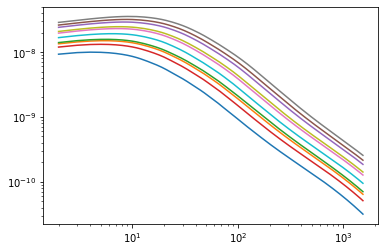

In [8]:
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        plt.loglog(cl_corrected[(i, j)][0][2:], cl_corrected[(i, j)][1][2:])

In [9]:
cosmo = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, n_s=0.97, sigma8=0.82)
ell = np.arange(3 * nside)

In [10]:
tracers = [ccl.WeakLensingTracer(cosmo, (sim_dict[i]['z'], sim_dict[i]['dNdz'])) for i in range(sim_dict['n_bins'])]

In [11]:
cl_ccl = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        cl_ccl[(i, j)] = ccl.cls.angular_cl(cosmo, tracers[i], tracers[j], ell)

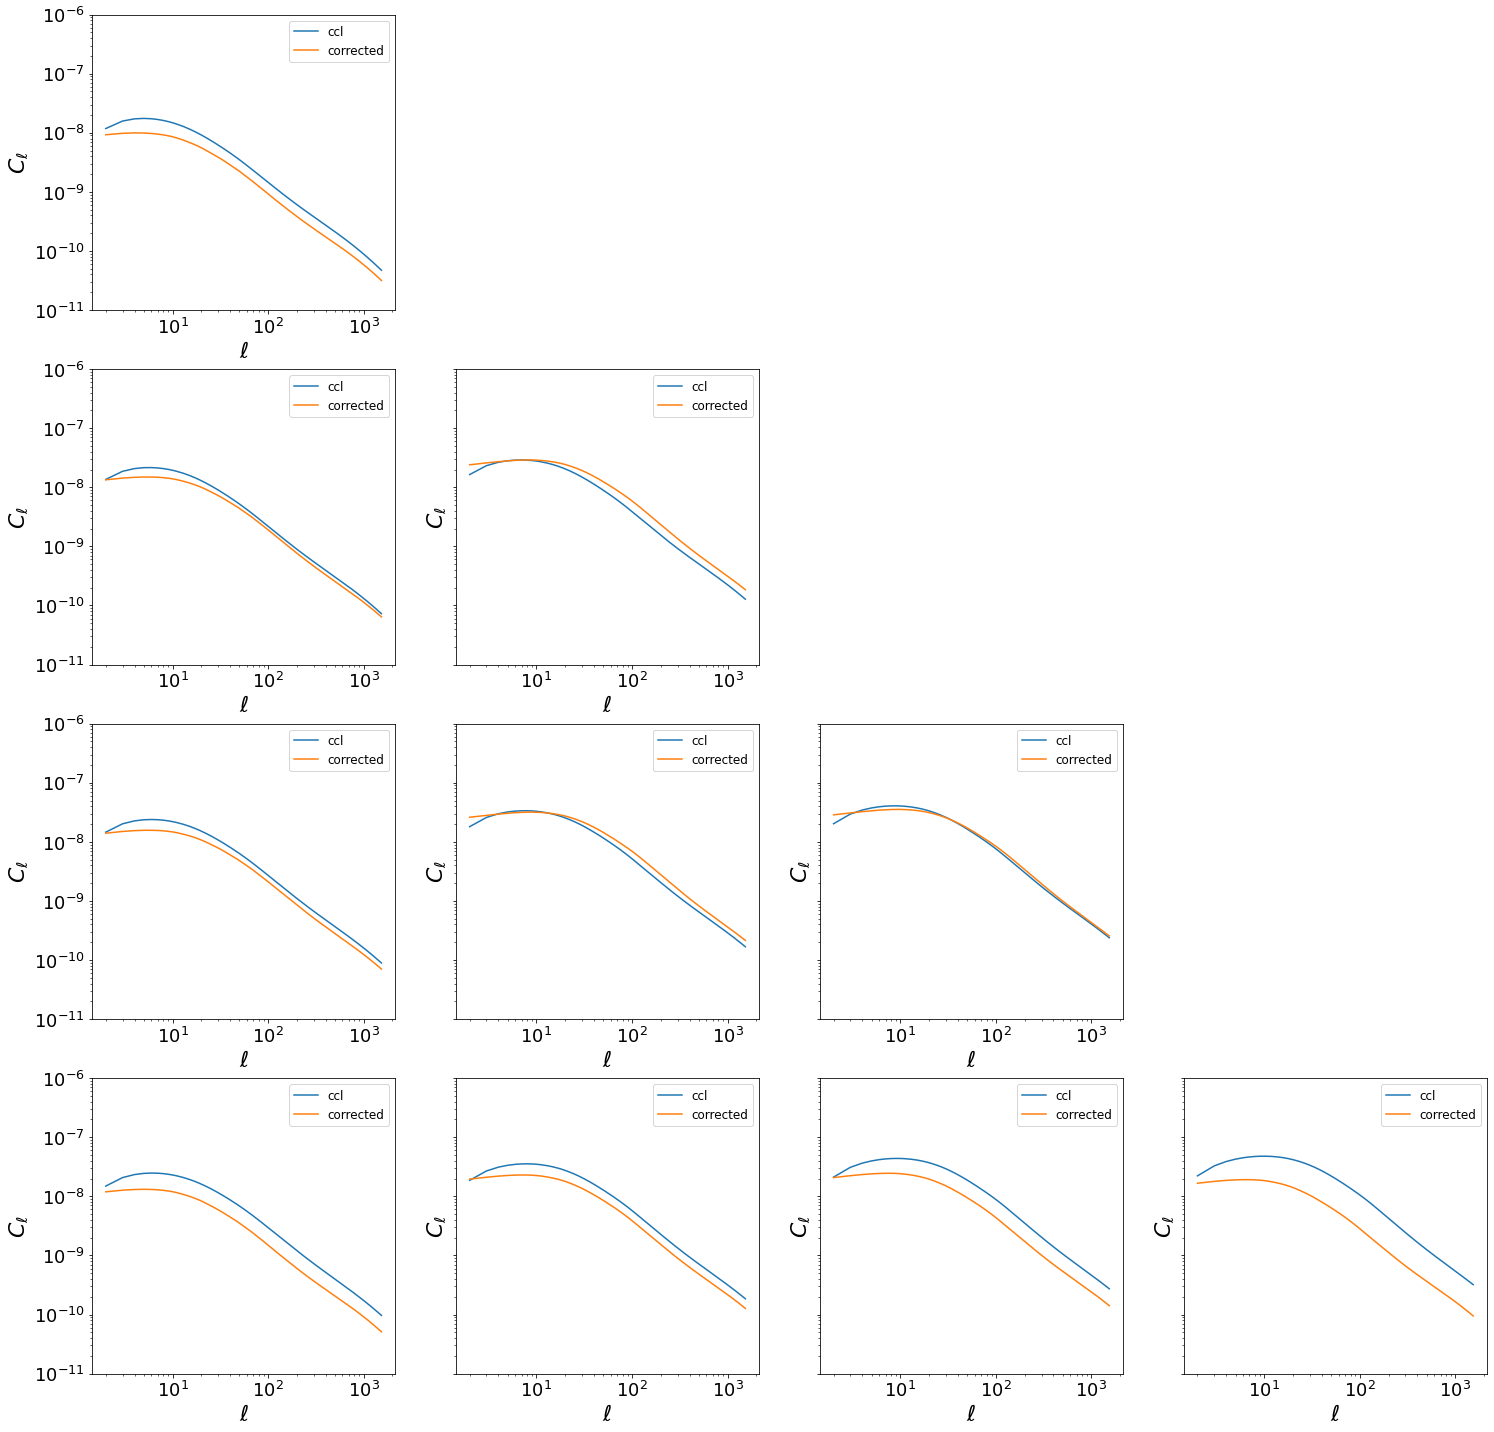

In [12]:
n_bins = sim_dict['n_bins']
fig, axs = plt.subplots(nrows=n_bins, ncols=n_bins, sharey='all', figsize=(25, 25))
axs[0, 0].set_ylim((1e-11, 1e-6))
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            axs[i, j].loglog(cl_corrected[(j, i)][0][2:], cl_ccl[(j, i)][2:], label='ccl')
            axs[i, j].loglog(cl_corrected[(j, i)][0][2:], cl_corrected[(j, i)][1][2:], label='corrected')
            axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
            axs[i, j].set_ylabel(r'$C_\ell$', fontsize=22)
            axs[i, j].tick_params(axis='both', labelsize=18)
            axs[i, j].legend(fontsize=12)
        else:
            axs[i, j].axis('off')

In [13]:
gaussian_maps = dict()
for i in range(sim_dict['n_bins']):
    _, cl = cl_corrected[(i, i)]
    gaussian_maps[i] = hp.sphtfunc.synfast([
        cl, cl, cl*0, cl, cl*0, cl*0
    ], nside, new=True, pol=True)

In [14]:
gamma1_map = dict()
gamma2_map = dict()
mask = dict()

for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    gamma1_map[i] = np.zeros(npix)
    gamma2_map[i] = np.zeros(npix)
    mask[i] = np.zeros(npix)
    
    gamma1_map[i][pixels[i]] += sim['g1']
    gamma2_map[i][pixels[i]] += sim['g2']
    mask[i][pixels[i]] += np.ones_like(sim['g2'])
    
    gamma1_map[i][mask[i] > 0] = np.divide(gamma1_map[i][mask[i] > 0], mask[i][mask[i] > 0])
    gamma2_map[i][mask[i] > 0] = np.divide(gamma2_map[i][mask[i] > 0], mask[i][mask[i] > 0])
    mask[i] = mask[i].astype('bool')

In [15]:
for i in range(sim_dict['n_bins']):
    gaussian_map = gaussian_maps[i]
    m = mask[i]
    gaussian_map[:, ~m] = hp.UNSEEN

In [16]:
def plot_mollview(maps):
    # Assuming overdensity, g1, g2
    for i, m in enumerate(maps):
        cmap = None if i == 0 else 'seismic'
        hp.mollview(m, cmap=cmap)

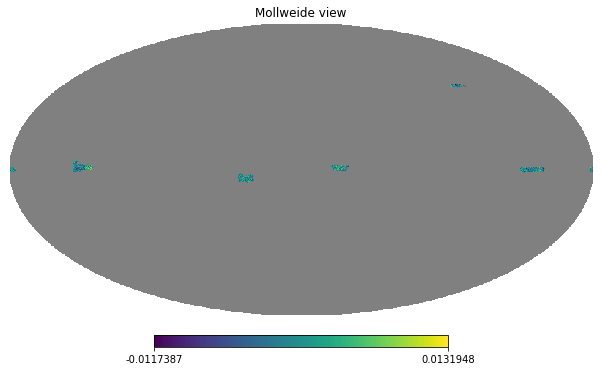

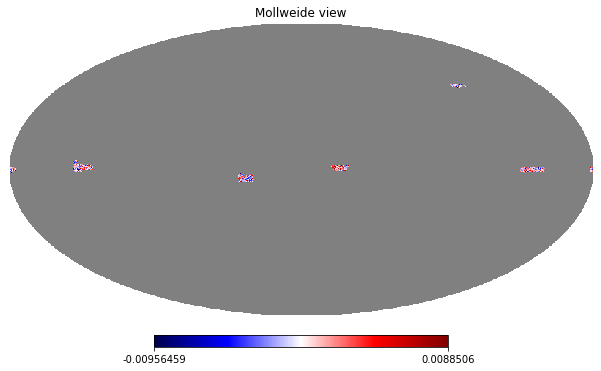

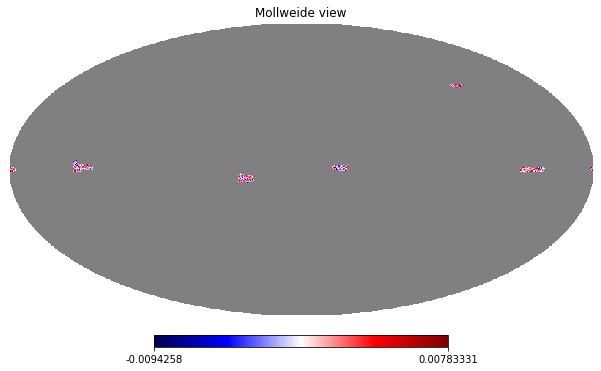

In [17]:
plot_mollview(gaussian_maps[0])

In [18]:
Dl_nmt = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        gmi = gaussian_maps[i]
        gmj = gaussian_maps[j]
        f2_i = nmt.NmtField(mask[i], [gmi[1], gmi[2]])
        f2_j = nmt.NmtField(mask[j], [gmj[1], gmj[2]])
        Dl = nmt.compute_coupled_cell(f2_i, f2_j)
        Dl_nmt[(i, j)] = Dl[0]
        del f2_i, f2_j, Dl

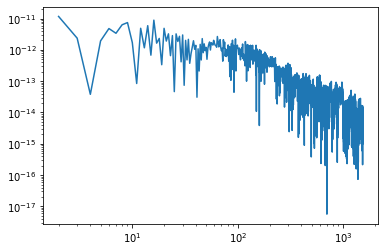

In [19]:
plt.loglog(cl_corrected[(0, 1)][0][2:], np.abs(Dl_nmt[(0, 1)][2:]))

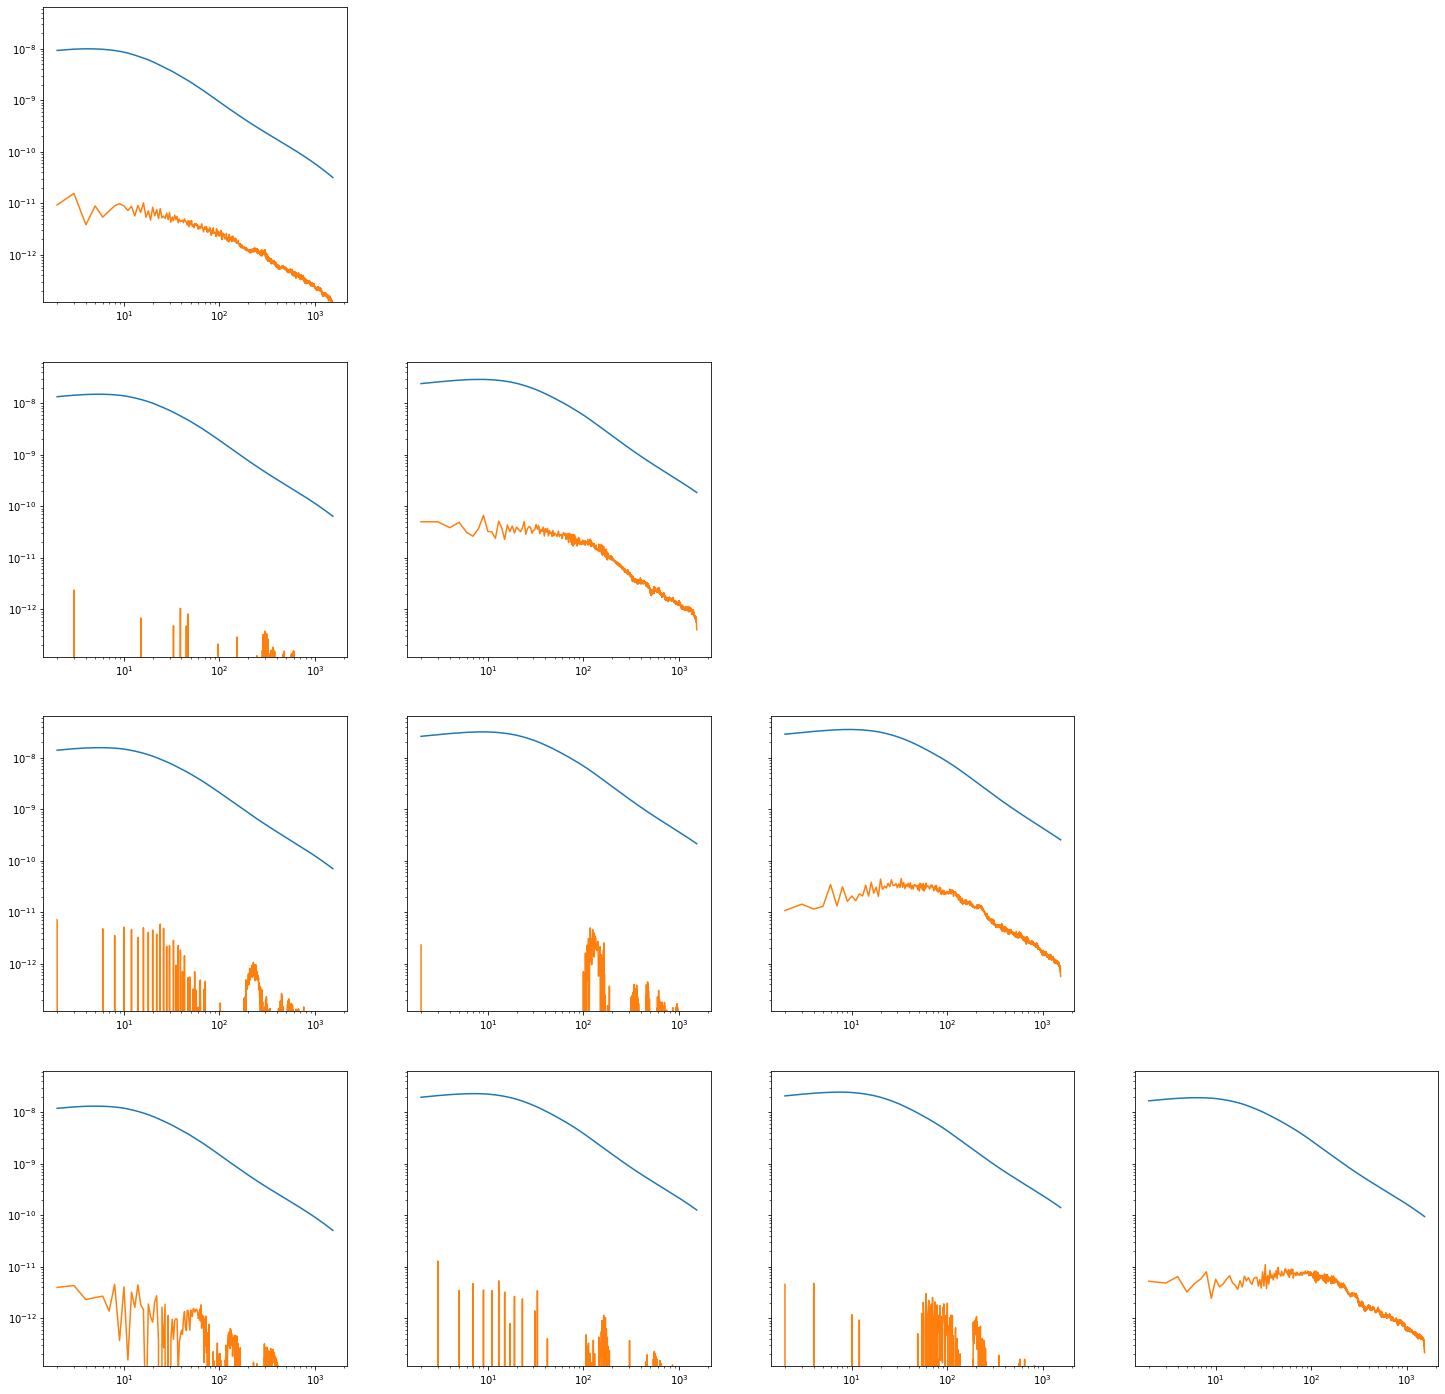

In [20]:
fig, axs = plt.subplots(nrows=n_bins, ncols=n_bins, sharey='all', figsize=(25, 25))
for i in range(sim_dict['n_bins']):
    for j in range(sim_dict['n_bins']):
        if j <= i:
            axs[i, j].loglog(cl_corrected[(j, i)][0][2:], cl_corrected[(j, i)][1][2:])
            axs[i, j].loglog(cl_corrected[(j, i)][0][2:], Dl_nmt[(j, i)][2:])
        else:
            axs[i, j].axis('off')

In [21]:
# HSC coverage is 1400 sq deg.
full_sky = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 137. / (full_sky)

In [22]:
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [23]:
shear_zbins=lsst_source_tomo_bins(nbins=sim_dict['n_bins'],use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'shear_zbins': None, 'kappa_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x147e14558a60>>
Win gen: step size 76 1536 31.0 10 False True
Window done. Size: 0.0


/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


In [24]:
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    shear_zbins[i]['z'] = sim['z']
    shear_zbins[i]['dz'] = np.gradient(sim['z'])
    shear_zbins[i]['pz'] = sim['dNdz']
    shear_zbins[i]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])
    shear_zbins[i]['window'] = mask[i]
    shear_zbins[i]['window_N'] = mask[i]

In [25]:
corrs = [corr_ll]
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,-2)

In [26]:
# pseudo_noise = f_sky * noise_power_spectrum

In [27]:
#setup parameters
lmax_cl = 3 * nside - 1 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 200 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 50

#l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

l = l0

In [28]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('galaxy', 'g

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x147e141cb0d0>>
Win gen: step size 100 1535 1536.0 1 True True
Win not found, computing now
get_Win, total cl keys:  10
set window_cl: cl0,cl_b done 0.00016307830810546875
set window_cl: cl done 0.03385329246520996 0.053000003 0.0
set_window_cl done 74.14000415802002
wigner_files: {0: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l5000_w5000_0_reorder.zarr', 2: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:40867' processes=1 threads=1, memory=51.56 GiB>
get_coupling_lm_all_win 100
got wig3j 100
done lm 100 46.653794050216675
get_coupling_lm_all_win 300
got wig3j 300
done lm 300 35.19031381607056
get_coupling_lm_all_win 1200
got wig3j 1200
done lm 1200 55.93890428543091
get_coupling_lm_all_win 200
got wig3j 200
do

In [29]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [30]:
cl_corrected.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)])

In [31]:
cl_sl = dict()
cl_sl_binned = dict()
cl_corrected_binned = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        M = SL_cl0.Win['cl'][corr_ll][(i, j)]['M']
        pcl_binned = SL_cl0.binning.bin_1d(Dl_nmt[(i, j)][lmin_cl:-1], bin_utils=SL_cl0.cl_bin_utils)
        cl_binned = SL_cl0.binning.bin_1d(cl_corrected[(i, j)][1][lmin_cl:-1], bin_utils=SL_cl0.cl_bin_utils)
        cl_corrected_binned[(i, j)] = cl_binned
        wt0 = 1. / cl_corrected[(i, j)][1][lmin_cl:-1]
        wt0[:2] = 0
        M_binned = SL_cl0.binning.bin_2d_coupling(M=M, wt0=wt0, 
                                                 wt_b=cl_binned, bin_utils=SL_cl0.cl_bin_utils)
        cl_sl[(i, j)] = Dl_nmt[(i, j)][lmin_cl:-1] @ np.linalg.pinv(M)
        cl_sl_binned[(i, j)] = pcl_binned @ np.linalg.pinv(M_binned)

/tmp/ipykernel_873599/3858866523.py:10: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_corrected[(i, j)][1][lmin_cl:-1]


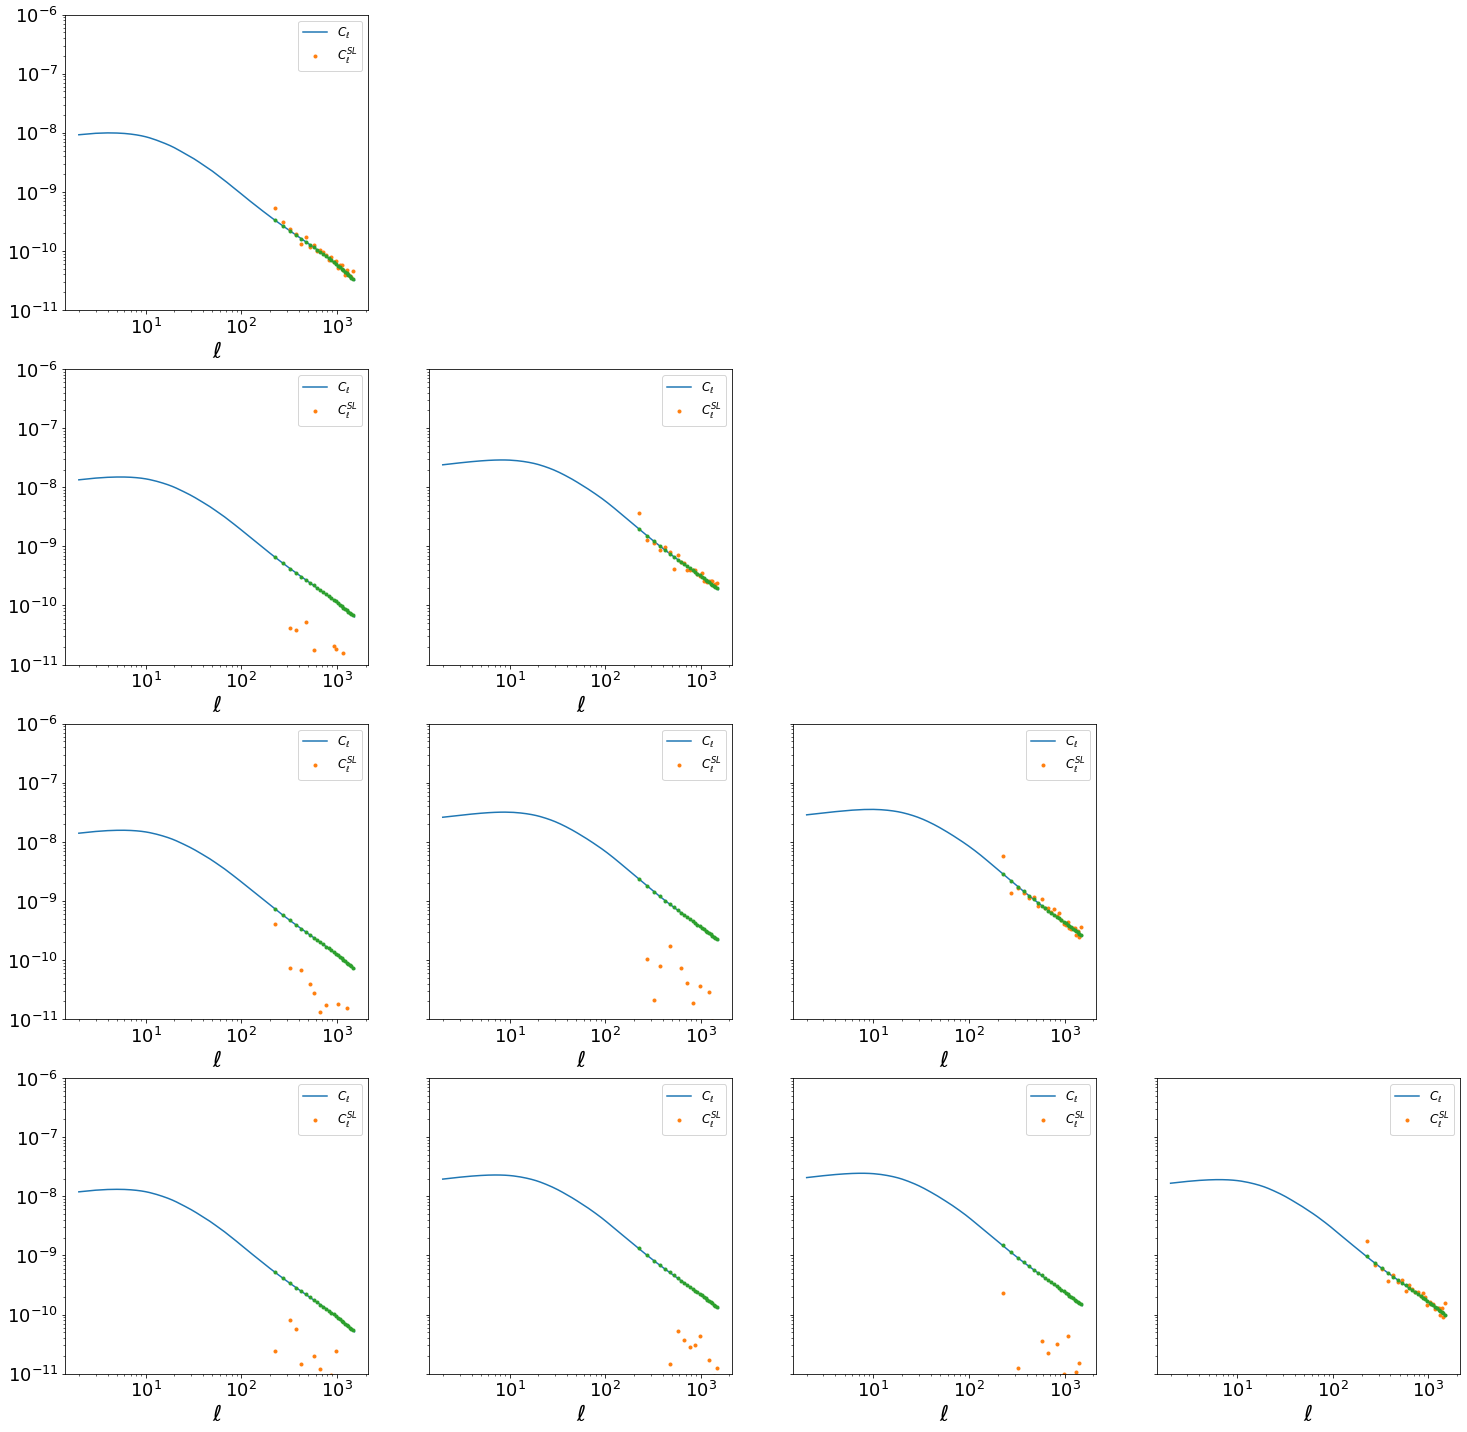

In [32]:
bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
ax_list = []
n_bins = sim_dict['n_bins']
fig, axs = plt.subplots(nrows=n_bins, ncols=n_bins, sharey='all', figsize=(25, 25))
axs[0, 0].set_ylim((1e-11, 1e-6))
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            
            axs[i, j].loglog(cl_corrected[(j, i)][0][2:], cl_corrected[(j, i)][1][2:], label=r'$C_\ell$')
            #plt.loglog(ell[2:], Dl_nmt[(j, i)][2:], label=r'$D_\ell$')
            #plt.loglog(ell[2:-1], np.abs(cl_sl[(j, i)][2:]), label=r'$C_\ell^{SL}$')
            axs[i, j].loglog(bc, cl_sl_binned[(j, i)], '.', label=r'$C_\ell^{SL}$')
            axs[i, j].loglog(bc, cl_corrected_binned[(j, i)], '.')
            axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
            axs[i, j].tick_params(axis='both', labelsize=18)
            axs[i, j].legend(fontsize=12)
        else:
            axs[i, j].axis('off')

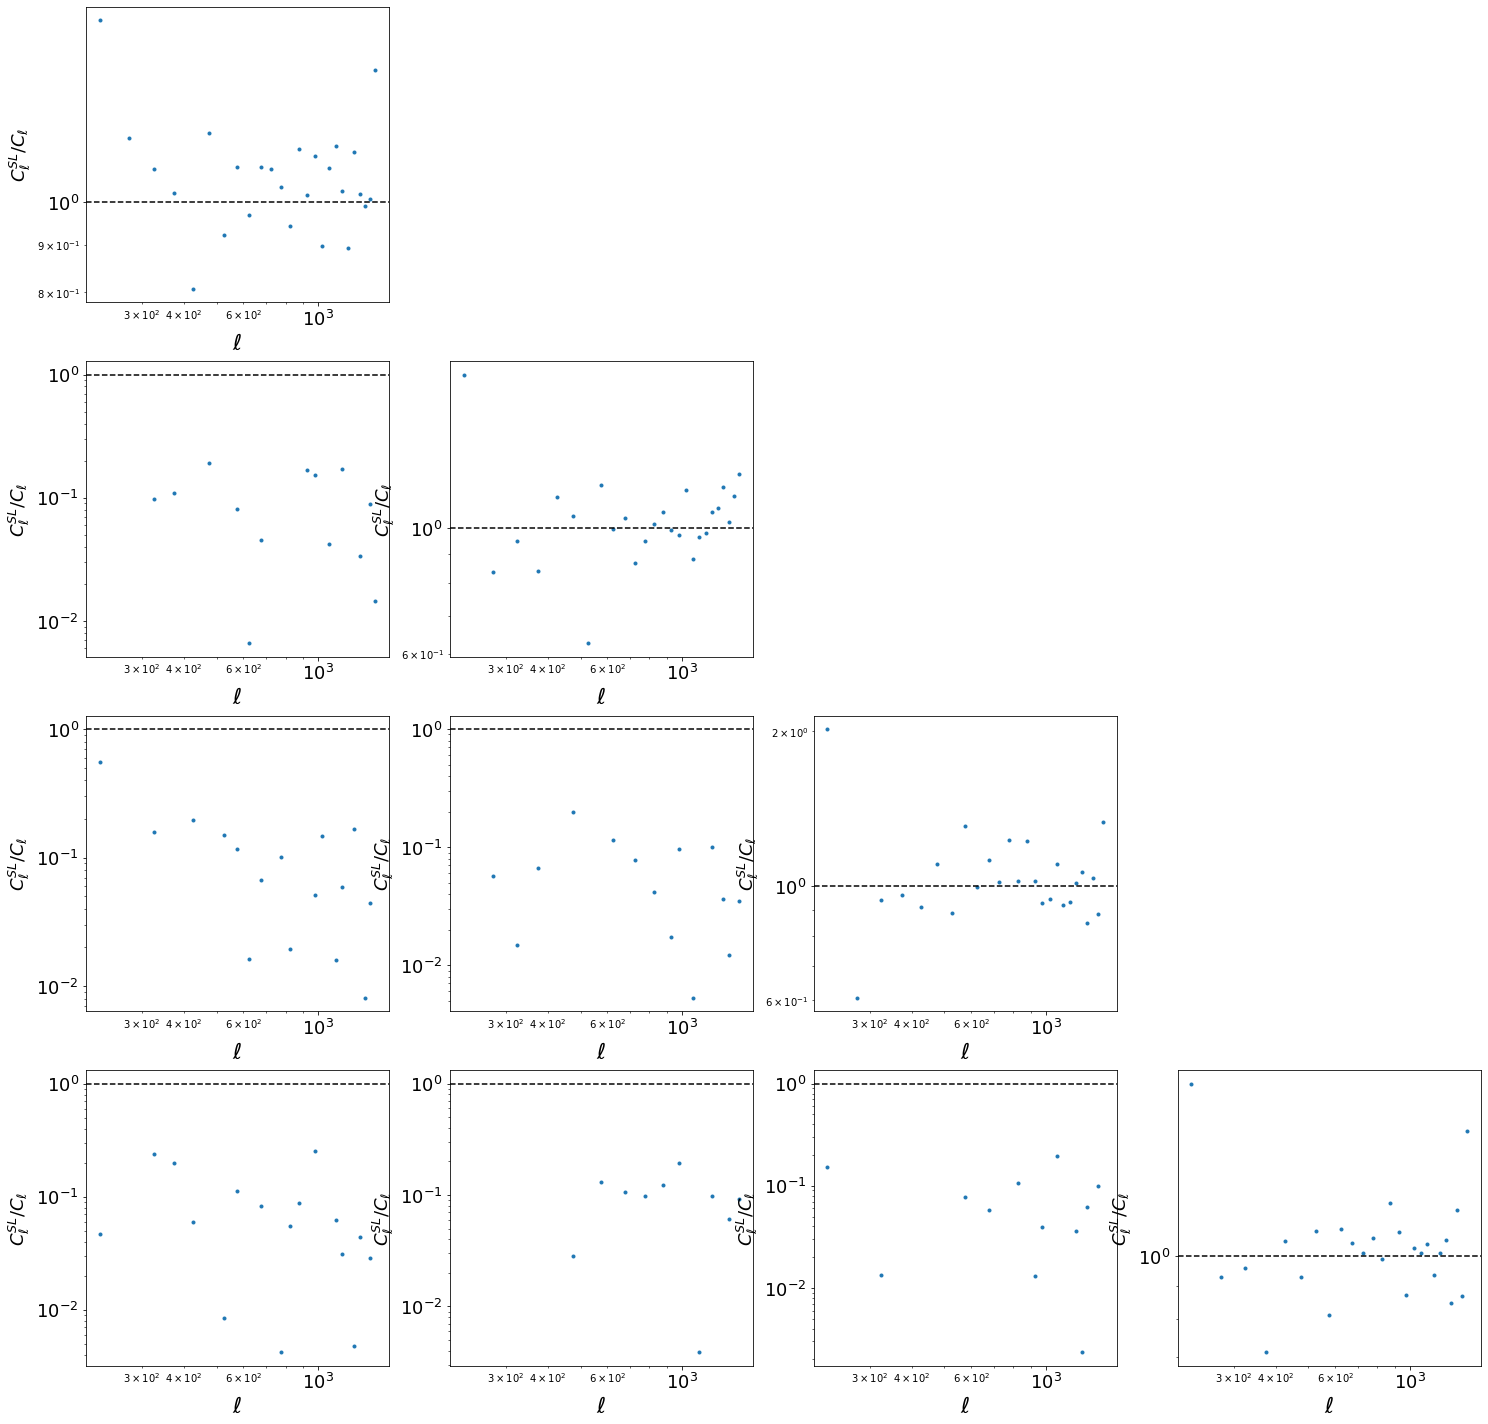

In [33]:
bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
plt.figure(figsize=(25, 25))
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            plt.subplot(n_bins, n_bins, i * n_bins + j + 1)
            plt.loglog(bc, cl_sl_binned[(j, i)] / cl_corrected_binned[(j, i)], '.')
            plt.xlabel(r'$\ell$', fontsize=22)
            plt.ylabel(r'$C_\ell^{SL} / C_\ell$', fontsize=18)
            plt.axhline(y=1., c='black', ls='--')
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            #plt.legend(fontsize=12)

In [34]:
d = np.concatenate((bc[None, :], np.array([cl for cl in cl_sl_binned.values()])))

In [35]:
nside, lmin_cl_Bins, lmax_cl_Bins, Nl_bins

(512, 200, 1525, 26)

In [36]:
f = f'../result/{nside}-{lmin_cl_Bins}-{lmax_cl_Bins}-{Nl_bins}.txt'
np.savetxt(f, d)

In [37]:
(2*200+1)*f_sky

1.3317104599557288

In [38]:
from matplotlib import gridspec

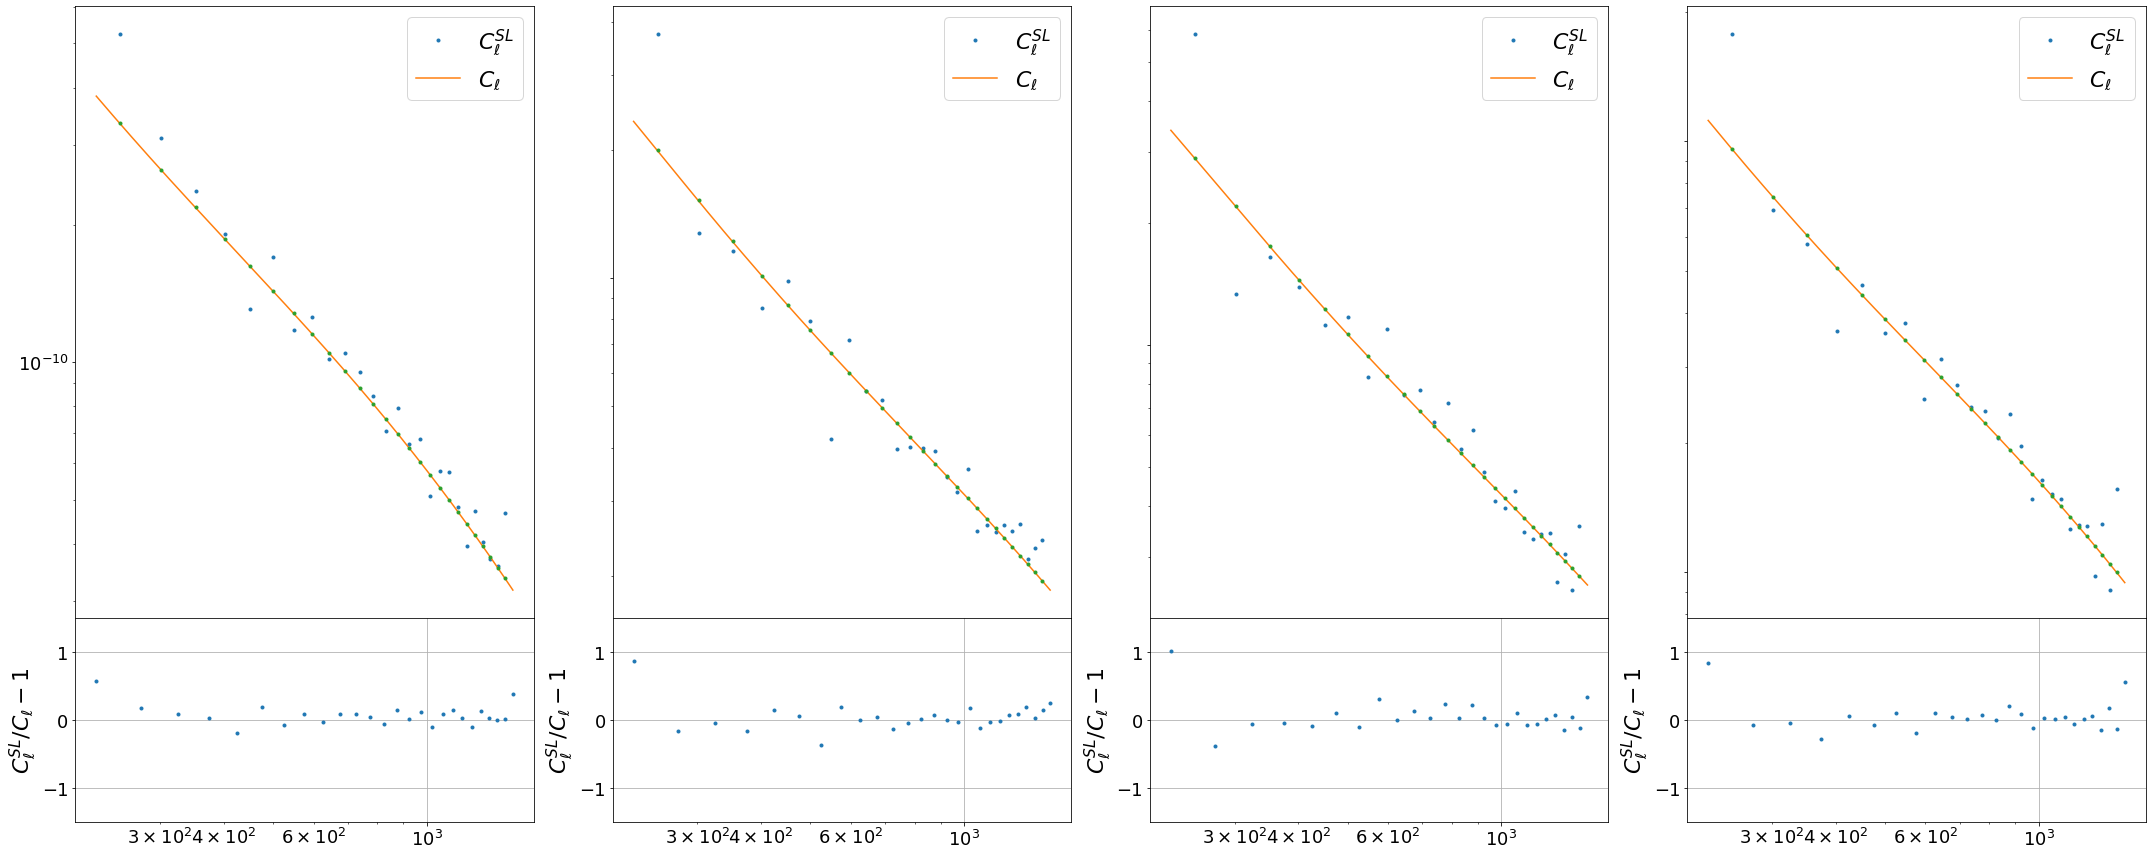

In [62]:
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], hspace=0) 
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    ax0, ax1 = plt.subplot(gs[0, i]), plt.subplot(gs[1, i])
    ax0.loglog(bc, cl_sl_binned[(i, i)], '.', label=r'$C_\ell^{SL}$')
    ax0.loglog(cl_corrected[(i, i)][0][lmin_cl_Bins:], cl_corrected[(i, i)][1][lmin_cl_Bins:], label=r'$C_\ell$')
    ax0.loglog(bc, cl_corrected_binned[(i, i)], '.')
    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    ax1.semilogx(bc, cl_sl_binned[(i, i)] / cl_corrected_binned[(i, i)] - 1, '.')
    ax1.grid(True)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_ylabel(r'$C_\ell^{SL} / C_\ell - 1$', fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()